# A|B Testing

Using an ab-test dataset from [Kaggle](https://www.kaggle.com/mursideyarkin/mobile-games-ab-testing-cookie-cats) with special thanks to **Mürşide Yarkın** how posted a great kaggle notebook on this dataset to get things started. *Yarkins notebook can be found under the 'Code' tab through the Kaggle link.*

<img src=https://i.ytimg.com/vi/LkvnfULq8yQ/maxresdefault.jpg style="max-width:350px">

## Cookie Cats Dataset
The following dataset contains information regarding an ab test conducted for a mobile game called **Cookie Cats**. There are two variants being A|B Tested called 'gate30' and 'gate40'. These gates refer to the level at which point a player is prompted to either wait a specified time or make a purchase before returning to the game. Retention is our key metric for this assignment to see whether or not a change from gate30 to gate40 will increase retention for the game. The column 'retention_1' refers to retention after a single day and 'retention_7' refers to rentention after a week. The column for either of the retention columns will be marked False if the player does not come back after the specified time and True if they return to the game within the same timeframe. For the context of this experiment 'userids' and 'sum_gamerounds' are not relevant.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
%matplotlib inline

### Loading the Data

In [2]:
df = pd.read_csv('data/cookie_cats.csv')
df = df.drop(['userid','sum_gamerounds'], axis=1)
df.head()

,version,retention_1,retention_7
0,gate_30,False,False
1,gate_30,True,False
2,gate_40,True,False
3,gate_40,False,False
4,gate_40,True,True


### Data Exploration
Our exploration phase is simply to find the retention rates for our variants 'gate30' and 'gate40' under 'retention_1' and 'retention_7'

In [3]:
#group totals
df.groupby('version').count()

,retention_1,retention_7
version,,
gate_30,44700,44700
gate_40,45489,45489


In [4]:
df_rates = df.groupby('version').sum()/df.groupby('version').count()
df_rates.rename(columns={'retention_1':'rate_1', 
                         'retention_7':'rate_7'}, inplace=True)

In [5]:
#retention rates
df_rates

,rate_1,rate_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


> We can see that there seems to be a slight decline when using gate_40 compared to gate_30. We will investigate this difference further...

#### Crosstabs for A|B Testing
We are creating two crosstabs from our dataframe to pass into our chi-square test just ahead

In [6]:
cross_1 = pd.crosstab(df.version, df.retention_1)
cross_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [7]:
cross_7 = pd.crosstab(df.version, df.retention_7)
cross_7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


### Chi-Square Test
We will be using a chi-square test to check for any significant difference between the distributions of 'gate30' and 'gate40'. This is not a test to see whether one should be implemented over the other, this test is simply to see if a significant difference exist between each group.

In [8]:
def chi_test(observed, expected):
    chi = chisquare(observed, expected)
    if chi[1] < 0.01:
        print(f'Significant at 1%: p-value = {chi[1]}')
    elif chi[1] < 0.05:
        print(f'Significant at 5%: p-value = {chi[1]}')
    else:
        print(print(f'Not Significant at 5%: p-value = {chi[1]}'))

In [9]:
#Crosstab 1
expected_1 = [cross_1[0][0], cross_1[1][0]]
observed_1 = [cross_1[0][1], cross_1[1][1]]
print(f'Expected for Retention_1:\n {expected_1}', '\n')
print(f'Observed for Retention_1:\n {observed_1}')

Expected for Retention_1:
 [24666, 20034] 

Observed for Retention_1:
 [25370, 20119]


In [10]:
#Chi Test for Retention_1
chi_test(observed_1, expected_1)

Significant at 1%: p-value = 6.109068351193552e-06


In [11]:
#Crosstab 1
expected_7 = [cross_7[0][0], cross_7[1][0]]
observed_7 = [cross_7[0][1], cross_7[1][1]]
print(f'Expected for Retention_7:\n {expected_7}', '\n')
print(f'Observed for Retention_7:\n {observed_7}')

Expected for Retention_7:
 [36198, 8502] 

Observed for Retention_7:
 [37210, 8279]


In [12]:
#Chi Test for Retention_7
chi_test(observed_7, expected_7)

Significant at 1%: p-value = 5.123532628219246e-09


> We have observed a significant difference at the 1% level so we have strong reason to believe that there is a difference between the distributions of 'gate30' and 'gate40' worth investigating

### Bootstrapping
We will now be using a bootstrapping technique to visualize the distributions of the mean retention rates for both 'gate30' and 'gate40'. By utilizing the central limit theorem we can create two sets of normal distributions by sampling our own data. Since the chi-square test gave us a strong implication that the distributions were different we should be able to distinguish between each gate fairly easily. We will use a sample of n=500 for our bootstrap method. Based on the visualizations we generate we should be able to determine our course of action 

In [13]:
# Our bootstrap function
def bootstrap(df, version:str, variant:str, sample_size:int = 500):
    boot_means = []
    for i in range(sample_size):
        boot_mean = df.sample(frac=1, replace=True).groupby(version)[variant].mean()
        boot_means.append(boot_mean)
    boot_df = pd.DataFrame(boot_means)
    return boot_df

In [14]:
boot_1 = bootstrap(df, version = 'version', variant ='retention_1')

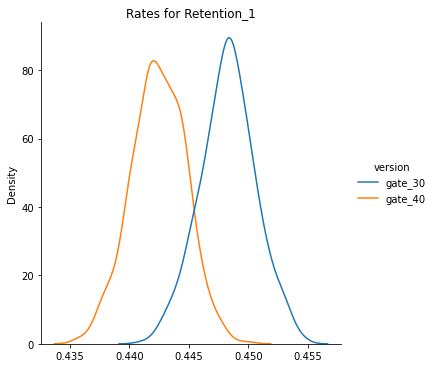

In [15]:
sns.displot(data=boot_1, kind='kde').set(title='Rates for Retention_1')

In [16]:
boot_7 = bootstrap(df, version = 'version', variant ='retention_7')

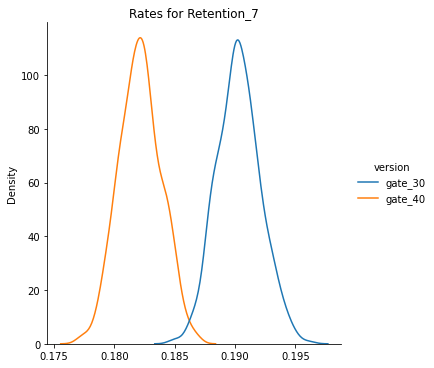

In [17]:
sns.displot(data=boot_7, kind='kde').set(title='Rates for Retention_7')

# Conclusion
Based on our results we can clearly see that 'gate40' is ultimately detrimental to our retention. In other words, players are not opening the game as often under the 'gate40' variant as they are when playing under the 'gate30' variant. We should recommend to our team that **'gate40' should not be implemented**. Sticking to 'gate30' will provide better results based on our analysis.